# Preview of data from Livox at Finse Flux Station
S. Filhol, Apr 2021

1. DEM preview
    - open, make little animation
    - Compare DEM to the first one
2. Cropped point cloud analysis
    - look at point cloud vertical distribution
    - derive precise snowdepth time series

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio import plot
import glob

1. DEM

In [2]:
path_to_data = '../data/LIVOXFinse/home/snowyowl/data/OUTPUT/'
tif_list = glob.glob(path_to_data+'*.tif')
tif_list.sort()

In [4]:
df = pd.DataFrame()
df['fname'] = tif_list
df['tst'] = pd.to_datetime(df.fname.apply(lambda x: x.split('/')[-1][:-4]),format='%Y.%m.%dT%H-%M-%S')

def open_rast(fname):
    return rio.open(fname)
def rast_extent(fname):
    r = rio.open(fname)
    return [r.bounds.left, r.bounds.right, r.bounds.bottom, r.bounds.top]

df['shape'] = df.fname.apply(lambda x: open_rast(x).shape)
df['geot'] = df.fname.apply(lambda x: open_rast(x).read_transform())
df['extent'] = df.fname.apply(lambda x: rast_extent(x))

Text(0.5, 1.0, 'Count - Apr 06, 2021')

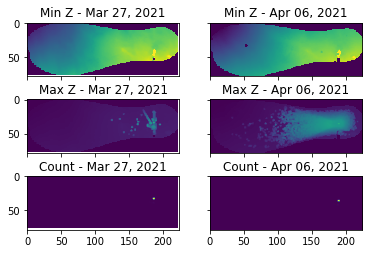

In [5]:
fig, axs = plt.subplots(3,2, sharex=True, sharey=True)
rast = rio.open(df.fname.iloc[0])
plot.show(rast.read(1),  vmin=-1, vmax=0.5, ax=axs[0,0])
plot.show(rast.read(2),  vmin=-1, vmax=16, ax=axs[1,0])
plot.show(rast.read(5), ax=axs[2,0])

axs[0,0].set_title('Min Z - ' + df.tst.iloc[0].strftime('%b %d, %Y'))
axs[1,0].set_title('Max Z - ' + df.tst.iloc[0].strftime('%b %d, %Y'))
axs[2,0].set_title('Count - ' + df.tst.iloc[0].strftime('%b %d, %Y'))
rast = rio.open(df.fname.iloc[-1])
plot.show(rast.read(1),  vmin=-1, vmax=0.5, ax=axs[0,1])
plot.show(rast.read(2),  vmin=-1, vmax=16, ax=axs[1,1])
plot.show(rast.read(5), ax=axs[2,1])

axs[0,1].set_title('Min Z - ' + df.tst.iloc[-1].strftime('%b %d, %Y'))
axs[1,1].set_title('Max Z - ' + df.tst.iloc[-1].strftime('%b %d, %Y'))
axs[2,1].set_title('Count - ' + df.tst.iloc[-1].strftime('%b %d, %Y'))

In [6]:
rast_ref = rio.open(df.fname.iloc[0])
rast_t = rio.open(df.fname.iloc[-1])
plt.figure()
plt.imshow(rast_t.read(1)[:,1:]-rast_ref.read(1))
plt.colorbar()
plt.title('Snow depth change (m) \n' + 
          df.tst.iloc[0].strftime('%b %d') + 
         ' - ' +
          df.tst.iloc[-1].strftime('%b %d, %Y'))

ValueError: operands could not be broadcast together with shapes (79,223) (77,222) 

<Figure size 432x288 with 0 Axes>

In [100]:
rast_extent(df.fname.iloc[0])

[-15.71, 6.289999999999999, -3.9000000000000004, 4.1]

In [101]:
rast_extent(df.fname.iloc[-1])

[-16.15, 7.850000000000001, -3.92, 4.08]

2. Point Clouds

In [7]:
from laspy import file
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [16]:
path_to_data = '../data/LIVOXFinse/Event_1_4-5/'
las_list = glob.glob(path_to_data+'*cropped.las')
las_list.sort()

In [17]:
las_list.__len__()

628

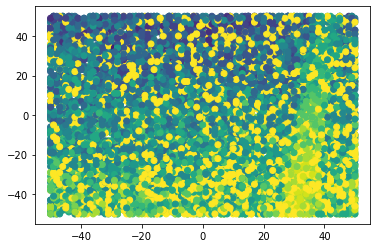

In [18]:
las = file.File(las_list[-10])
plt.figure()
plt.scatter(las.get_x(), las.get_y(), c=las.get_z(), vmin=15, vmax=30)
#plt.ylim([0,100])

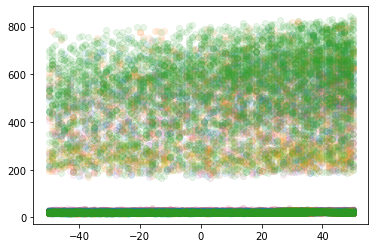

In [21]:

plt.figure()
for i in range(0, 628, 50):
    plt.scatter(file.File(las_list[i]).get_x(), file.File(las_list[i]).get_z(), alpha=.1)

In [32]:
%matplotlib

Using matplotlib backend: Qt5Agg


### Ideas to correlate point cloud noise to precipitation

Precip from point clouds
- look at absolute number of points per scan
- look at centroid of point per scan, with standard deviation
- look at mean/meadian distance in between points
- 

Create a dataframe to extract stats from the point cloud

Download data from wsn database:
    - geonor
    - flowcapt 1 and 2
    - RH
    


In [51]:
dg = pd.DataFrame()
dg['fname'] = las_list
dg['tst'] = pd.to_datetime(dg.fname.apply(lambda x: x.split('/')[-1][:-11]), format='%Y.%m.%dT%H-%M-%S')
dg = dg.set_index(dg.tst)

In [57]:
def extract_cloud_precip(fname):
    mylas = file.File(fname)
    df = pd.DataFrame()
    df['x'] = mylas.get_x()[mylas.get_z()>100]
    df['y'] = mylas.get_y()[mylas.get_z()>100]
    df['z'] = mylas.get_z()[mylas.get_z()>100]
    return df
 
dg['p_count'] = dg.fname.apply(lambda x: extract_cloud_precip(x).shape[0])
dg['z_mean'] = dg.fname.apply(lambda x: extract_cloud_precip(x).z.mean())
dg['z_median'] = dg.fname.apply(lambda x: extract_cloud_precip(x).z.median())
dg['z_std'] = dg.fname.apply(lambda x: extract_cloud_precip(x).z.std())
dg['x_mean'] = dg.fname.apply(lambda x: extract_cloud_precip(x).x.mean())
dg['y_mean'] = dg.fname.apply(lambda x: extract_cloud_precip(x).y.mean())
dg['x_median'] = dg.fname.apply(lambda x: extract_cloud_precip(x).x.median())
dg['y_median'] = dg.fname.apply(lambda x: extract_cloud_precip(x).y.median())

In [78]:
%matplotlib
fig, axs = plt.subplots(2,1, sharex=True)
dg.z_mean.plot(ax=axs[0])
axs[0].fill_between(dg.tst, (dg.z_mean-dg.z_std).values, (dg.z_mean+dg.z_std).values, alpha=.2)

dg.p_count.plot(ax=axs[1])#, logy=True)
(dg.p_count*0+1000).plot(ax=axs[1], c='k')

Using matplotlib backend: Qt5Agg


<AxesSubplot:xlabel='tst'>

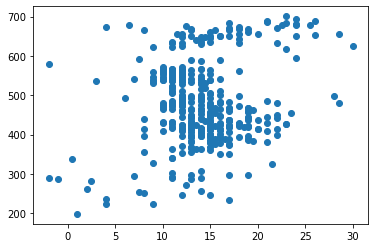

In [71]:
plt.scatter(dg.x_median.loc[dg.p_count>100], dg.z_median.loc[dg.p_count>100])

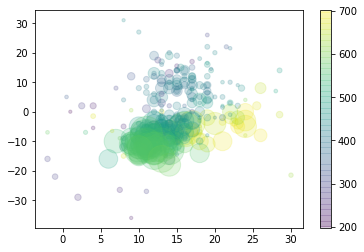

In [77]:
plt.scatter(dg.x_median.loc[dg.p_count>100], dg.y_median.loc[dg.p_count>100], c=dg.z_median.loc[dg.p_count>100], alpha=.2, s=dg.p_count.loc[dg.p_count>100]/10)
plt.colorbar()